In [8]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import StaleElementReferenceException
import os
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np 
import glob
import time
import yfinance as yf
import datetime


# options = Options()
# options.add_argument("--start-maximized")  # Maximize the browser window
# options.add_argument("--disable-extensions")
# options.add_argument("--disable-popup-blocking")
# options.add_argument("--disable-infobars")
# options.add_argument("--no-sandbox")
# options.add_argument("--disable-dev-shm-usage")
# options.add_argument("--disable-gpu")
# options.add_argument("--ignore-certificate-errors")

#driver = webdriver.Chrome()
#driver = webdriver.Safari()

ERROR = False

cookies_ec_dict = {'google': EC.element_to_be_clickable((By.XPATH, "//div[@class='QS5gu sy4vM']")),
                'nasdaq': EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")),
                'investing.com':EC.element_to_be_clickable((By.ID, "onetrust-accept-btn-handler")),
                'zacks.com_readmore': EC.visibility_of_element_located((By.XPATH, "//button[contains(@class, 'Button__StyledButton') and contains(text(), 'Read more to accept preferences')]")),
                'zacks.com': EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'Button__StyledButton-a1qza5-0') and contains(text(), 'Accept all')]"))}

nav_nasdaq_ec_dict = {'select_date': EC.element_to_be_clickable((By.ID, "date-picker__toggle")),
                            #"//button[@class='date-picker__toggle' and @aria-label='click show datepicker popup']")),      
                      'select_searchbox':  EC.visibility_of_element_located((By.CLASS_NAME, "date-picker__input")),
                      'apply_date_button': EC.element_to_be_clickable((By.XPATH,
                            "//button[@class='date-picker__apply']"))}

nav_investingcom_ec_dict = {'select_calendar': EC.element_to_be_clickable((By.ID, "datePickerToggleBtn"))}

def accept_cookies(site = 'google'):   
    if site == 'zacks.com':
        try:
            read_more = WebDriverWait(driver, 1).until(cookies_ec_dict['zacks.com_readmore']) 
            read_more.click()
        except:
            print("No 'Read more' button found on ", site)
    try:
        accept = WebDriverWait(driver, 1).until(cookies_ec_dict[site])
        accept.click()
    except:
        print("No 'Accept' button found or unable to click on ", site)


def google(query, cookies):
    # Open the website
    driver.get("https://google.com")
    if cookies: accept_cookies('google')
    search_box = driver.find_element(By.NAME, "q")

     # Enter your search query
    search_query = query
    search_box.send_keys(search_query)

    # Simulate hitting Enter
    search_box.send_keys(Keys.RETURN)

def click_google_site(site):
    driver.find_element(By.XPATH, f"//a[contains(@href, '{site}')]").click()

def select_date(year, month, day, site = 'nasdaq'):
    if site == 'nasdaq':
        date = datetime.date(year, month, day).strftime('%m/%d/%Y')
        WebDriverWait(driver, 1).until(nav_nasdaq_ec_dict['select_date']).click()
        driver.execute_script(f"document.querySelector('.date-picker__input').value = '{date}';")
        WebDriverWait(driver, 1).until(nav_nasdaq_ec_dict['e_button']).click()
    elif site == 'investing.com':
        date = datetime.date(year, month, day).strftime('%m/%d/%Y')
        WebDriverWait(driver, 1).until(nav_investingcom_ec_dict['select_calendar']).click()
        input_element = driver.find_element(By.CSS_SELECTOR, "input.newInput#startDate")
        input_element.clear()  # Clear any existing value
        input_element.send_keys(date)  
        input_element = driver.find_element(By.CSS_SELECTOR, "input.newInput#endDate")
        input_element.clear()  # Clear any existing value
        input_element.send_keys(date)  
        driver.find_element(By.ID, 'applyBtn').click()
            
def google_site(query, site, cookies):
    google(query, cookies)
    click_google_site(site)


def get_symbols(site, openclose = False):
    time.sleep(1)

    symbols = []
    if openclose: timings = []
    if site == 'investing.com':
        openclose_dict = {'1': 'open', '2': 'none', '3': 'close'}
        table = driver.find_element(By.ID, "earningsCalendarData")
        tbody = table.find_element(By.TAG_NAME, "tbody")
        rows = tbody.find_elements(By.TAG_NAME, "tr")
        # Iterate over each table row
        for index, row in enumerate(rows):
            if index == 0: continue
            try:
                inner_html = row.get_attribute("innerHTML")
                soup = BeautifulSoup(inner_html, "html.parser")
                a_element = soup.find("a", class_="bold middle")
                if openclose:
                    timing_element = soup.find("td", class_="right time")
                    timing_value = timing_element.get("data-value")
                    timings.append(openclose_dict[timing_value])
                if a_element:
                    company = a_element.text.strip()
                    symbols.append(company)
            except Exception as e:
                print(f"Error processing row {index}: {e}")
                continue
    if openclose: return symbols, timings
    return symbols

def search_on(website, query):
    if website == 'zacks.com':
        search_input = WebDriverWait(driver, 20).until(
            EC.visibility_of_element_located((By.ID, "search-q"))
        )
        # Input the search query
        search_input.send_keys(query)
        # Press ENTER to submit the form
        search_input.send_keys(Keys.ENTER)


def get_rank(website):
    if website == 'zacks.com':
        try:
            # Wait for the paragraph element to be visible
            rank_paragraph = WebDriverWait(driver, 20).until(
                EC.visibility_of_element_located((By.CLASS_NAME, "rank_view"))
            )

            # Get the text of the paragraph element
            rank_text = rank_paragraph.text.strip()
            return int(rank_text[0])
        
        except Exception as e:
            ERROR = True

            
def analyst(website, symbol, cookies):
    if website == 'zacks.com':
        driver.get(f'https://www.zacks.com/stock/quote/{symbol}?q={symbol}')
    else:
        google_site(f'{website[:website.find(".")]} {symbol}', website, cookies)
    if cookies: accept_cookies(website)
    rank = get_rank(website)
    return rank
   
def earnings_rank(website, year, month, day, path = ''):
    if path != '':
        if path[-1] == '/': path = path[:-1]
    if os.path.exists(path+'/'+f'{year}-{month}-{day}') is False:   
        print('path does not exist')
    else:
        for index, tickerpath in enumerate(glob.glob(path+'/'+f'{year}-{month}-{day}/*/')):
            ticker = tickerpath[len(path+'/'+f'{year}-{month}-{day}/'):-1]
            rank = analyst(website, ticker, cookies = not(index))
            print(ticker, rank)
            with open(tickerpath+website, 'a') as f:
                f.write(f'{datetime.datetime.today().year}-{datetime.datetime.today().month}-{datetime.datetime.today().day},    {rank}\n')


def get_tickers_for_earnings_date(year, month, day, openclose = False):
    google_site('earnings calendar', 'investing.com', cookies = True)
    accept_cookies('investing.com')
    time.sleep(0.5)
    select_date(year, month, day, site = 'investing.com')
    if openclose: 
        tickers, timings = get_symbols('investing.com', openclose = openclose)
        return tickers, timings
    else:
        tickers = get_symbols('investing.com', openclose = openclose)
        return tickers
 

def make_earnings_dates_directories(path, year, month, day, tickers, openclose  = None):
    if path[-1] == '/': path = path[:-1]
    if os.path.exists(path) is False:
        os.mkdir(path)
    if os.path.exists(path+'/'+f'{year}-{month}-{day}') is False:
        os.mkdir(path+'/'+f'{year}-{month}-{day}')  
    for index, ticker in enumerate(tickers):
        if os.path.exists(path+'/'+f'{year}-{month}-{day}/'+ ticker) is False:
            os.mkdir(path+'/'+f'{year}-{month}-{day}/'+ ticker)
        if openclose is not None:
            with open(path+'/'+f'{year}-{month}-{day}/'+ ticker + '/openclose.dat', 'a') as f:
                f.write(openclose[index])

    
         
def filter_by_lastrank(path, year, month, day, website):
    if path != '':
        if path[-1] == '/': path = path[:-1]
    if os.path.exists(path+'/'+f'{year}-{month}-{day}') is False:   
        print('path does not exist')
    else:
        ranks = ['1','2','3','4','5','None']
        ticker_rank = {rank:[] for rank in ranks}
        for _, tickerpath in enumerate(glob.glob(path+'/'+f'{year}-{month}-{day}/*/')):
            ticker = tickerpath[len(path+'/'+f'{year}-{month}-{day}/'):-1]
            with open(tickerpath+website, 'r') as f:
                text = f.read()
                last = text.split(' ')[-1]
                ticker_rank[last[:last.find('\n')]].append(ticker)

        return ticker_rank



##########################################


In [102]:
driver = webdriver.Chrome()
year, month, day = 2024, 3, 19
tickers, timings = get_tickers_for_earnings_date(year, month, day, openclose = True)
driver.quit()

In [103]:
for tic, tim in zip(tickers, timings):
    print(tic, tim)

ZTO none
TME open
CNM none
XPEV open
AIR none
SLNO none
EVV none
ORLA none
ORIC none
HUYA open
ABSI none
DEC open
ACIU none
SCPH none
CLRB none
KGEI none
CMCM none
KRON none
DRIO none
AATC none
SNCE none
XGN none
SOLO none
UAMY none
SSKN none
TBIO none
NROM none
JT none
WEBB none
GADS none
GENN none
GCFB none


In [104]:
make_earnings_dates_directories('earnings', year, month, day, tickers, openclose = timings)


In [105]:
driver = webdriver.Chrome()
earnings_rank('zacks.com', year, month, day, path = 'earnings')
driver.quit()

No 'Read more' button found on  zacks.com
GCFB None
KGEI 5
XPEV 3
CNM 3
UAMY None
SLNO 4
JT None
SCPH 4
SNCE None
AATC None
CLRB 3
KRON 4
ORIC 3
ORLA 4
AIR 4
WEBB None
DRIO 4
HUYA 3
SOLO 3
CMCM None
EVV None
DEC 4
TBIO 3
ZTO 4
ABSI 2
NROM None
ACIU 3
SSKN 3
GENN None
GADS None
XGN 2
TME 3


In [107]:
year, month, day = 2024, 3, 6
ticker_rank = filter_by_lastrank('earnings', year, month, day, 'zacks.com')

In [111]:
for i in range(1,3):
    print(f'{i}: ', ticker_rank[f'{i}'], '\n')

1:  ['LGGNY', 'EVGO', 'OSPN', 'SUPV'] 

2:  ['TRIN', 'ANF', 'CURLF', 'XERS', 'STOK', 'KFY', 'EWCZ', 'HNST', 'LYRA', 'DHLGY'] 



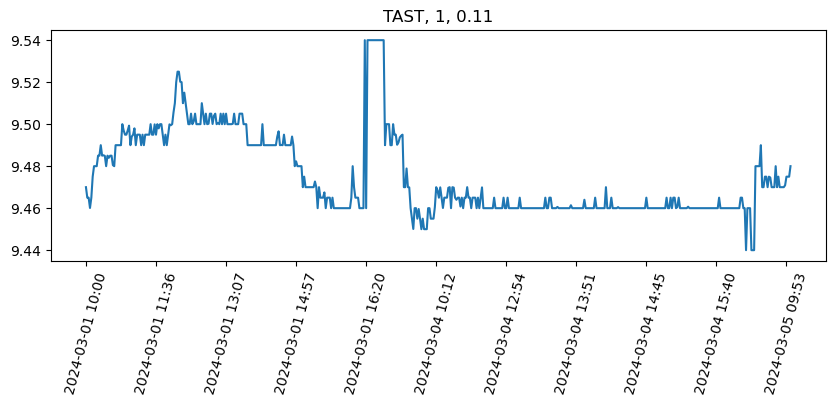

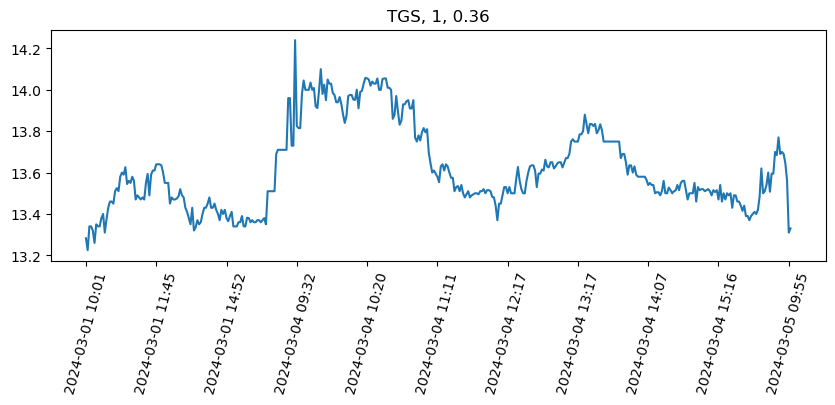

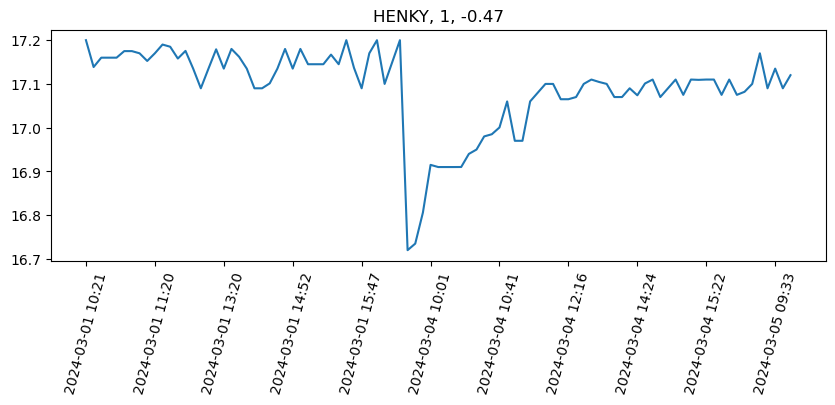

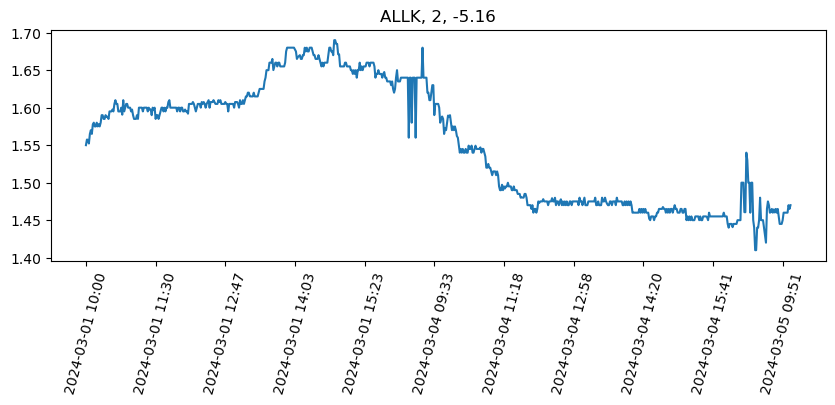

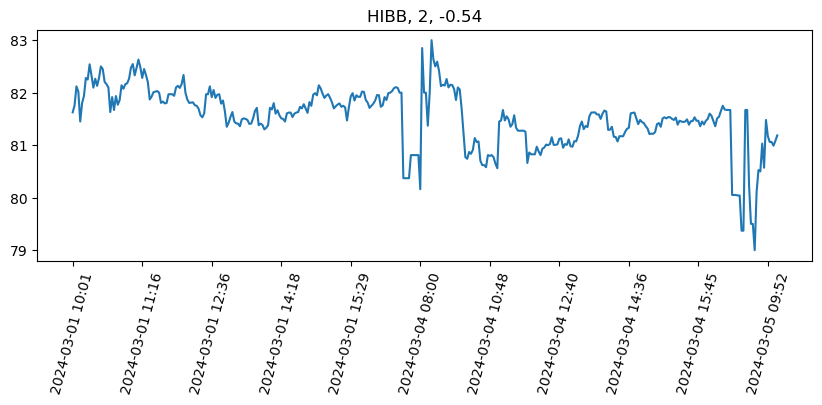

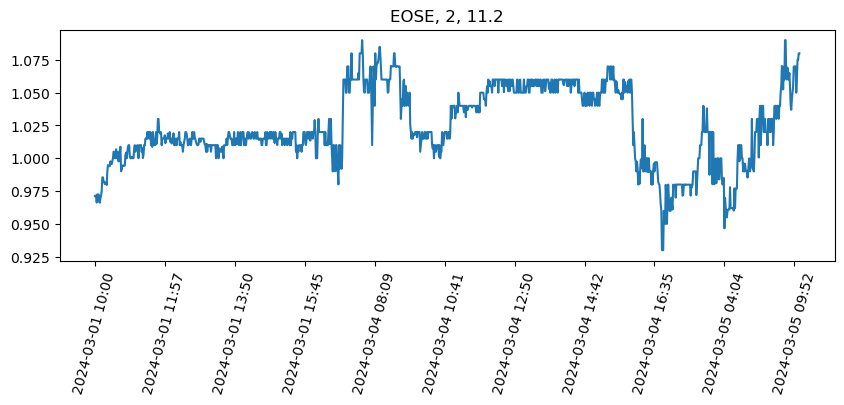

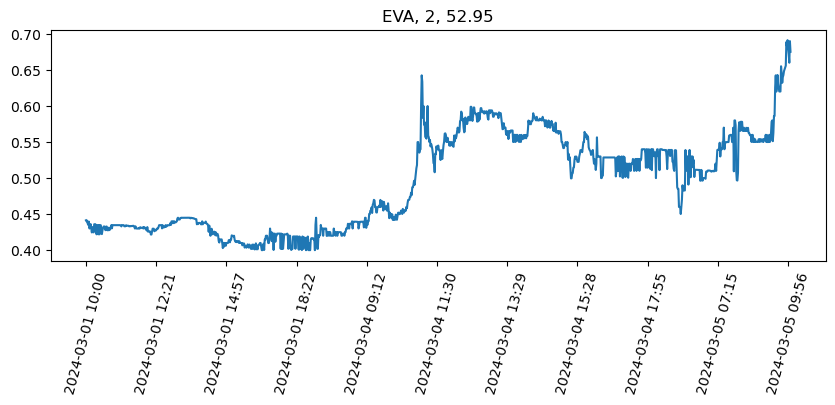

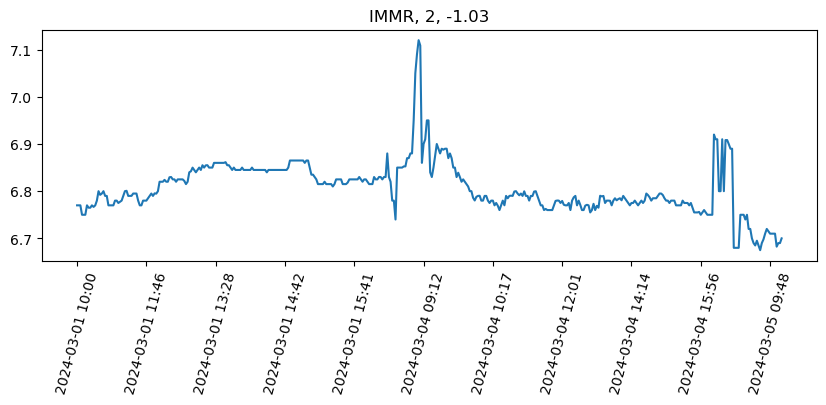

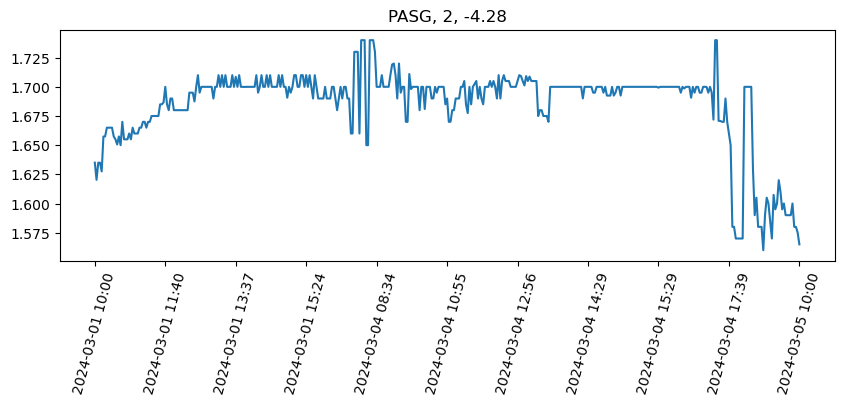

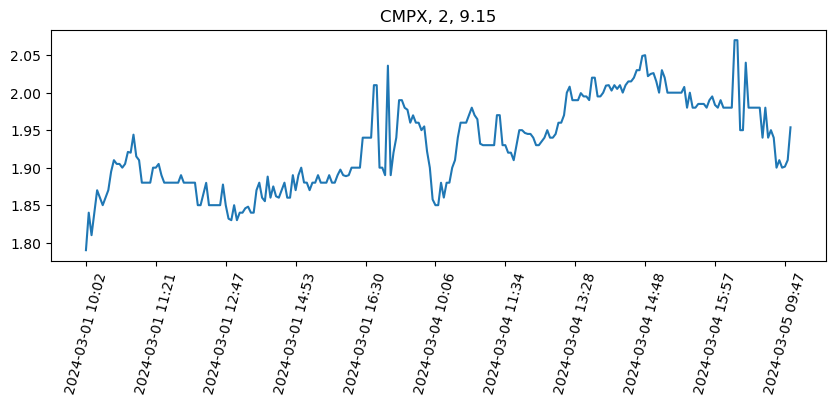

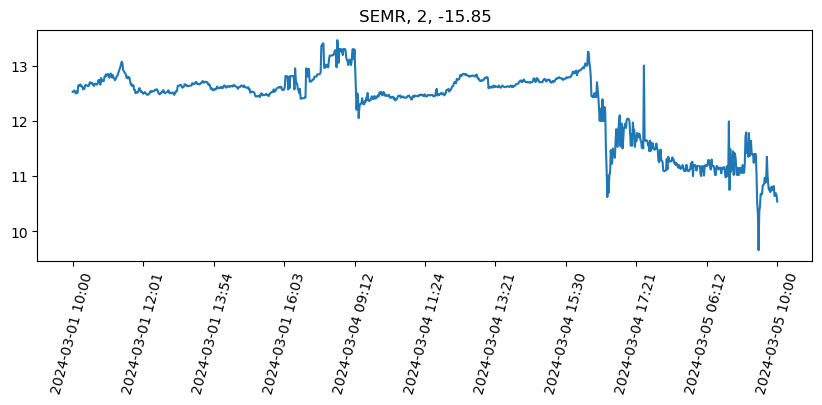

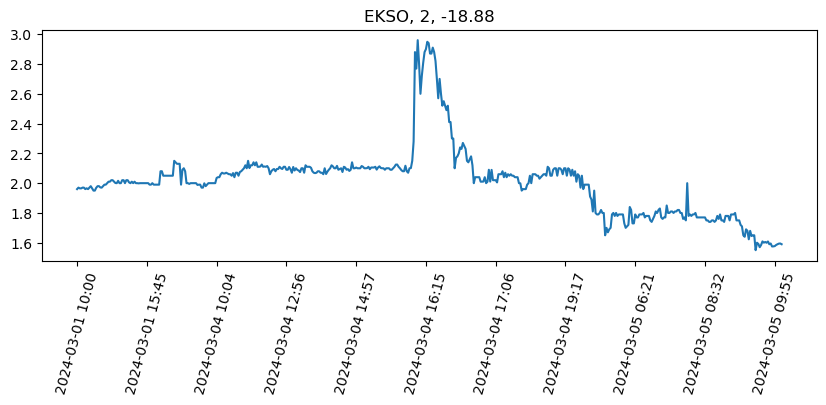

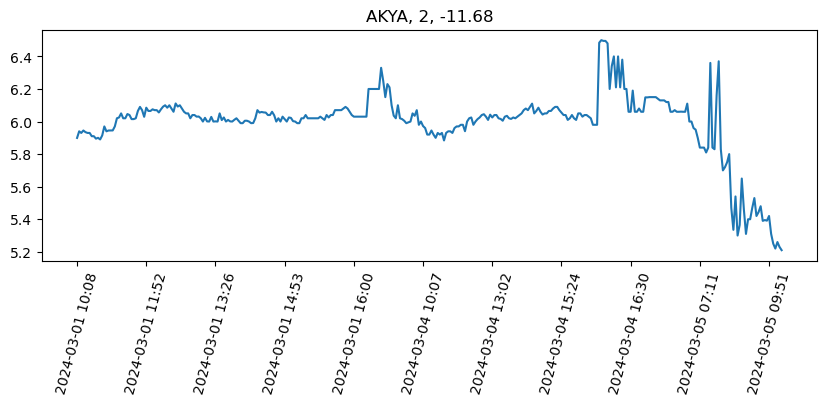

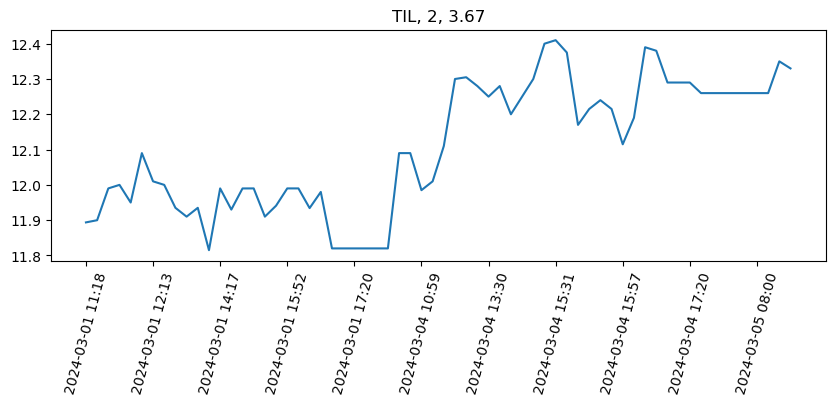

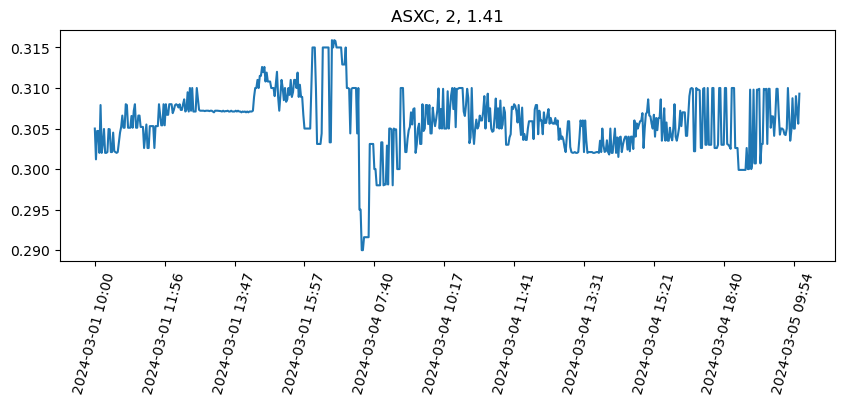

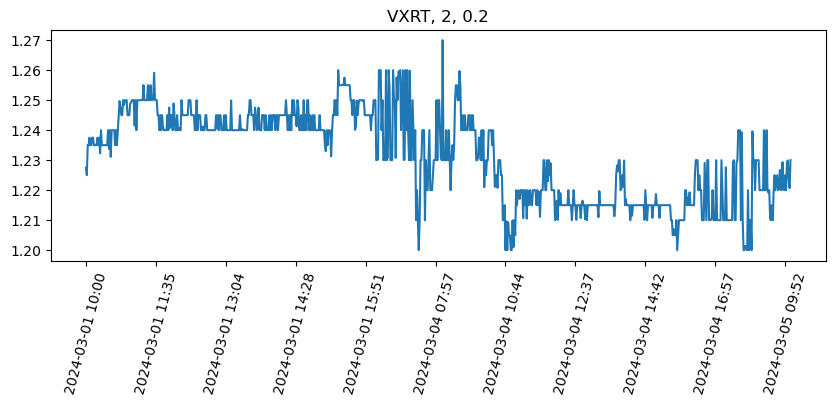

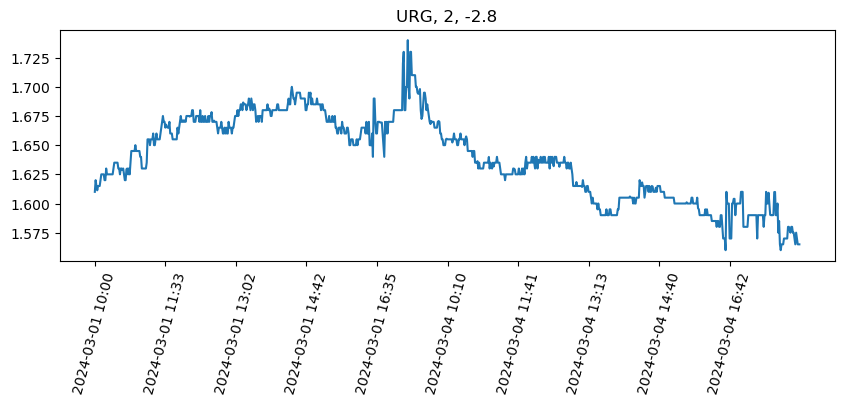

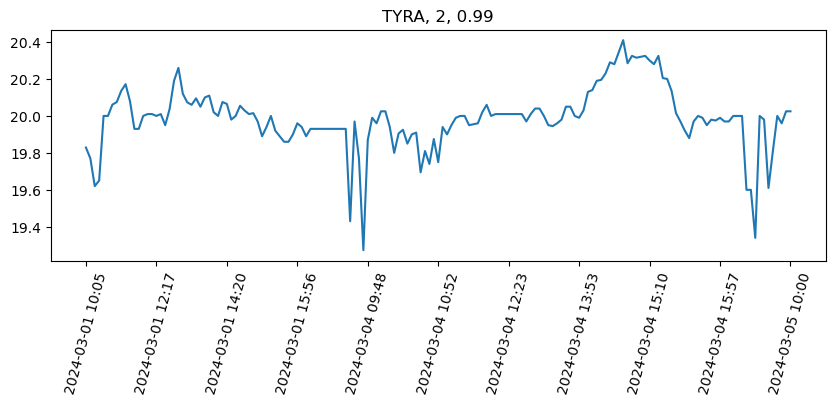

In [89]:
year, month, day = 2024, 3, 4
ticker_rank = filter_by_lastrank('earnings', year, month, day, 'zacks.com')
how_many_xticks = 10
initial_value_per_ticker = 1
total_initial_value = 0
total_final_value = 0
plot = True
total_percentage = 0
for i in range(1,3):
    for tic in ticker_rank[f'{i}']:
        yf_ticker = yf.download(tickers=tic, start='2024-03-01', end ='2024-03-06', interval="1m", prepost = True, progress=False, ignore_tz=True)
        open_values = yf_ticker['Open']['2024-03-01 10:00':'2024-03-05 10:00'].values
        percentage_difference = round((open_values[-1] - open_values[0])/open_values[0]*100,2)
        total_percentage += percentage_difference
        if len(open_values)//how_many_xticks:
            total_initial_value += initial_value_per_ticker
            total_final_value += initial_value_per_ticker*(1+percentage_difference)
            xticks = np.arange(len(open_values))[::len(open_values)//how_many_xticks]
            xlabels = [str(timestamp)[:-3] for timestamp in yf_ticker['Open']['2024-03-01 10:00':'2024-03-05 10:00'].index[::len(open_values)//how_many_xticks]]
            if plot:
                plt.figure(figsize = (10,3))
                plt.plot(open_values)
                plt.title(f'{tic}, {i}, {percentage_difference}')
                plt.xticks(xticks, xlabels, rotation = 75)
                plt.show()
                plt.close()


In [90]:
total_initial_value, total_final_value, (total_final_value - total_initial_value)/total_initial_value*100, total_percentage

(18, 37.350000000000016, 107.50000000000009, 19.349999999999994)

In [54]:
yf_ticker.shape

(1165, 6)

In [41]:
yf_ticker['Open']['2024-02-28 04:00:00':'2024-02-28 05:46:00']

Datetime
2024-02-28 04:00:00    9.51
2024-02-28 04:14:00    9.51
2024-02-28 05:46:00    9.51
Name: Open, dtype: float64

In [45]:
yf_ticker[yf_ticker.index == '2024-02-28 04:00:00']

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-02-28 04:00:00,9.51,9.51,9.51,9.51,9.51,0


In [51]:
np.argwhere(np.array(yf_ticker.index) == '2024-02-28T04:00:00.000000000')

/var/folders/9g/bzb1c3hn6jvdx57km19ky1y00000gn/T/ipykernel_42886/3472928210.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  np.argwhere(np.array(yf_ticker.index) == '2024-02-28T04:00:00.000000000')


array([], shape=(0, 0), dtype=int64)

In [50]:
np.array(yf_ticker.index)

array(['2024-02-28T04:00:00.000000000', '2024-02-28T04:14:00.000000000',
       '2024-02-28T05:46:00.000000000', ...,
       '2024-03-05T11:30:00.000000000', '2024-03-05T11:31:00.000000000',
       '2024-03-05T11:33:00.000000000'], dtype='datetime64[ns]')

In [112]:
ticker = yf.Ticker('DELL')

In [116]:
hist = ticker.history()
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-02-02 00:00:00-05:00,85.629997,86.900002,85.220001,86.320000,3683600,0.0,0.0
2024-02-05 00:00:00-05:00,86.529999,86.870003,84.760002,85.709999,2204200,0.0,0.0
2024-02-06 00:00:00-05:00,85.730003,85.989998,82.160004,82.680000,5013800,0.0,0.0
2024-02-07 00:00:00-05:00,83.440002,83.830002,82.779999,83.739998,2964200,0.0,0.0
2024-02-08 00:00:00-05:00,83.610001,85.139999,83.510002,84.800003,2993800,0.0,0.0
2024-02-09 00:00:00-05:00,85.250000,86.650002,85.010002,86.199997,2315700,0.0,0.0
2024-02-12 00:00:00-05:00,86.500000,86.889999,85.830002,86.620003,2979100,0.0,0.0
2024-02-13 00:00:00-05:00,84.989998,85.190002,83.449997,83.980003,3144300,0.0,0.0
2024-02-14 00:00:00-05:00,85.059998,86.230003,84.720001,86.040001,2361300,0.0,0.0


In [115]:
hist

<bound method log_indent_decorator.<locals>.wrapper of yfinance.Ticker object <DELL>>

In [94]:
hist['Low']['2024-02-02']

85.22000122070312

In [128]:
ticker = yf.download(tickers="DELL", period="5d", interval="1m", prepost = True, ignore_tz=True)

[*********************100%%**********************]  1 of 1 completed


In [129]:
# start = datetime.datetime(2021, 10, 18, 9, 30, 0)
# end = datetime.datetime(2021, 10, 18, 10, 30, 0)

# filtered = ticker[start: end]
# filtered

ticker['2024-03-01']

/var/folders/9g/bzb1c3hn6jvdx57km19ky1y00000gn/T/ipykernel_33969/453447690.py:7: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ticker['2024-03-01']


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-03-01 04:00:00,114.000,114.93,113.0000,114.11,114.11,0
2024-03-01 04:01:00,114.480,114.82,114.4700,114.82,114.82,0
2024-03-01 04:02:00,114.800,115.00,114.5700,114.60,114.60,0
2024-03-01 04:03:00,114.600,114.79,114.1100,114.79,114.79,0
2024-03-01 04:04:00,114.770,115.00,114.7400,114.91,114.91,0
...,...,...,...,...,...,...
2024-03-01 19:55:00,124.190,124.20,124.1492,124.15,124.15,0
2024-03-01 19:56:00,124.150,124.25,124.1100,124.19,124.19,0
2024-03-01 19:57:00,124.200,124.20,124.0000,124.00,124.00,0


In [135]:
str(ticker.index[0]).split(' ')[-1]

'04:00:00'

['04:00',
 '05:21',
 '06:51',
 '07:54',
 '08:17',
 '08:44',
 '09:05',
 '09:42',
 '10:02',
 '10:22',
 '10:42',
 '11:02',
 '11:22',
 '11:42',
 '12:02',
 '12:22',
 '12:42',
 '13:02',
 '13:22',
 '13:42',
 '14:02',
 '14:22',
 '14:42',
 '15:02',
 '15:22',
 '15:42',
 '16:02',
 '16:25',
 '16:46',
 '17:10',
 '17:34',
 '17:58',
 '18:33',
 '18:56',
 '19:35',
 '04:08',
 '05:38',
 '06:56',
 '07:24',
 '08:04',
 '08:27',
 '08:48',
 '09:09',
 '09:44',
 '10:04',
 '10:24',
 '10:44',
 '11:04',
 '11:24',
 '11:44',
 '12:04',
 '12:24',
 '12:44',
 '13:04',
 '13:24',
 '13:44',
 '14:04',
 '14:24',
 '14:44',
 '15:04',
 '15:24',
 '15:44',
 '16:04',
 '16:24',
 '16:44',
 '17:04',
 '17:24',
 '17:44',
 '18:04',
 '18:24',
 '18:44',
 '19:04',
 '19:24',
 '19:44',
 '04:04',
 '04:24',
 '04:44',
 '05:04',
 '05:24',
 '05:45',
 '06:05',
 '06:25',
 '06:45',
 '07:05',
 '07:25',
 '07:45',
 '08:05',
 '08:25',
 '08:45',
 '09:05',
 '09:40',
 '10:00',
 '10:20',
 '10:40',
 '11:00',
 '11:20',
 '11:40',
 '12:00',
 '12:20',
 '12:40',
